In [1]:
import numpy as np
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
import multiprocessing

## COLD ATOM

In [61]:
Transparency_Omega_1 = None
Transparency_Omega_2 = None
Om_2_list_adapted = None

# Constants
epsilon_0 = 8.854e-12  # Vacuum permittivity (F/m)
hbar = 1.054e-34       # Reduced Planck's constant (J·s)
mu_13 = 1.366e-29     # Dipole moment between states (|1> and |3>) (C·m)
mu_23 = 1.058e-29     # Dipole moment between states (|2> and |3>) (C·m)

Gamma3 = 2 * np.pi * 6   # (MHz)
Gamma31 = 0.5 * Gamma3   # Decay from level 3 to level 1 (MHz)
Gamma32 = Gamma23 = 0.5 * Gamma3   # Decay from level 3 to level 2 (MHz)
Gamma12 = Gamma21 = 0 * Gamma3    # Decay rates between levels 1 and 2 (MHz)
gamma13 = (Gamma3 + Gamma12)/2  # Decoherence rate between levels 1 and 3 (MHz)
gamma23 = (Gamma3 + Gamma21)/2  # Decoherence rate between levels 2 and 3 (MHz)
gamma12 = (Gamma12 + Gamma21)/2     # Decoherence rate between ground states (MHz)

w_1 = 2 * np.pi * 3.771120414e14
w_2 = 2 * np.pi * 3.771052067e14
k_1 = w_1 / 3e8
k_2 = w_2 / 3e8
L = 0.02        # Length in meters
z = 0.00001    # Step size in meters

OD_0 = 10
N = OD_0 / ((4 * np.pi * mu_13**2 * L) / (Gamma3 * 10**6 * hbar * epsilon_0 * 795e-9))

print("{:.2e}".format(N))

# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):

    Om_2_initial = 2.0
    
    Om_2_list = Om_2_initial * Gamma3 + 0j
    Om_1_list = Om_1 * Gamma3 + 0j
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    # Initialize arrays to store rho31 and rho32
    rho31_values = np.zeros((nz), dtype=complex)
    rho32_values = np.zeros((nz), dtype=complex)

    for i in range(nz):
        if i == nz/4 or i == nz/2 or i == 3*nz/4: 
            print(f"Processing z step {i}/{nz}")
        
        Om_2_actual = Om_2_list      # Convert to actual Omega_2 in MHz
        Om_1_actual = Om_1_list      # Convert Om_1 to MHz

        delta_1_actual = delta_1 * Gamma3
        delta_2_actual = delta_2 * Gamma3
        
        # Construct A and b as per Code2
        # Define the imaginary unit
        I = 1j

        # Construct the matrix A
        A = np.array([
            # Row 1
            [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
            # Row 2
            [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
            # Row 3
            [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
            # Row 4
            [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
            # Row 5
            [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
            # Row 6
            [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
            # Row 7
            [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
            # Row 8
            [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
        ], dtype=complex)

        # Construct the vector b
        b = np.array([
            Gamma31,
            0,
            I*np.conjugate(Om_1_actual)/2,
            0,
            Gamma32,
            I*np.conjugate(Om_2_actual)/2,
            -I*Om_1_actual/2,
            -I*Om_2_actual/2
        ], dtype=complex)

        # Solve the linear system A * v = b
        try:
            v = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            # Handle singular matrix
            print("nan")
            return [np.nan] * 8  # Return an array of NaNs

        # Extract the solutions
        rho11 = np.real(v[0])
        rho12 = v[1]
        rho13 = v[2]
        rho21 = v[3]
        rho22 = np.real(v[4])
        rho23 = v[5]
        rho31 = v[6]
        rho32 = v[7]

        # Compute rho33
        rho33 = 1 - rho11 - rho22

        # Update the Rabi frequencies
        Om_2_list = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32 * mu_23**2 / (10**6)
        Om_1_list = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31 * mu_13**2 / (10**6)
        
        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list)
        Om_1_vs_z.append(Om_1_list)
    
    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_vs_z, Om_1_vs_z, z_array, N, OD_0, Om_2_initial

def plot_OD(Om_1: list,delta_1: list, delta_2):
    
    Om_2_vs_z, Om_1_vs_z, z_array, N, OD_0, Om_2_initial = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Extract real and imaginary parts
    Om_1_real = np.real(Om_1_vs_z)
    Om_1_imag = np.imag(Om_1_vs_z)
    Om_2_real = np.real(Om_2_vs_z)
    Om_2_imag = np.imag(Om_2_vs_z)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot Omega_1
    plt.subplot(2, 1, 1)
    plt.plot(z_array, np.abs(Om_1_vs_z) / (Om_1 * Gamma3), label='Omega_1')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_1 (MHz)')
    plt.title(f'Omega_1 vs z\nOD_0={OD_0}, N={N:.2e}, Omega_1={Om_1} MHz')
    plt.legend()
    plt.ylim(0, 1.1)
    plt.grid(True)

    # Plot Omega_2
    plt.subplot(2, 1, 2)
    plt.plot(z_array, np.abs(Om_2_vs_z) / (Om_2_initial * Gamma3), label='Omega_2')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_2 (MHz)')
    plt.title(f'Omega_2 vs z\nOD_0={OD_0}, N={N:.2e}, Omega_2={Om_2_initial} MHz')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = 1
    delta_1 = 0.5
    delta_2 = 0
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)

w_1 = 3.77e+14
5.96e+15


Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

## HOT ATOM

Total area under Maxwellian: 0.9968903440652314


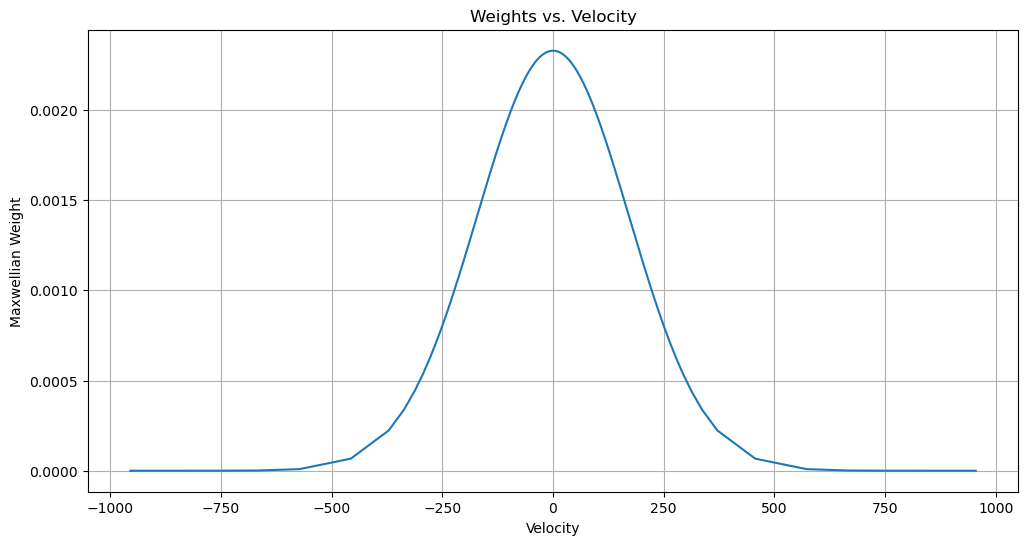

In [71]:
# Maxwell-Boltzmann distribution function
def Maxwellian(V):
    return (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-V**2 / (2 * sigma**2))

# Number of velocity points
nv = 151
v_values = np.zeros(nv)
dv = np.zeros(nv)
dv_min = 2  # Reduced minimum velocity increment for better resolution

# Middle index (centered at zero velocity)
mid_index = nv // 2
v_values[mid_index] = 0
dv[mid_index] = dv_min * 2

# Area under Maxwellian at zero velocity
area = dv[mid_index] * Maxwellian(0)

# Compute positive velocities
for m in range(mid_index + 1, nv):
    v_end = v_values[m - 1] + dv[m - 1] / 2

    # Define the function to find the root of
    def func(V):
        return Maxwellian((V + v_end) / 2) * (V - v_end) - area

    # Improved initial guess for V
    V_guess = v_end + dv_min

    # Use fsolve to find V such that func(V) = 0
    V_solution = fsolve(func, V_guess, xtol=1e-8, maxfev=1000)[0]

    # Update velocity and dv arrays
    v_values[m] = (V_solution + v_end) / 2
    dv[m] = V_solution - v_end

# Reflect to get negative velocities
v_values[:mid_index] = -np.flip(v_values[mid_index + 1:])
dv[:mid_index] = np.flip(dv[mid_index + 1:])

# Maxwell-Boltzmann distribution weights
weights = Maxwellian(v_values)

#print(v_values)
#print(weights)

# Verify that the total area under the curve approximates 1
total_area = np.sum(weights * dv)
print('Total area under Maxwellian:', total_area)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(v_values, weights)
plt.title('Weights vs. Velocity')
plt.xlabel('Velocity')
plt.ylabel('Maxwellian Weight')
plt.grid(True)
plt.show()

Button(button_style='success', description='Run Simulation', icon='play', style=ButtonStyle(), tooltip='Click …

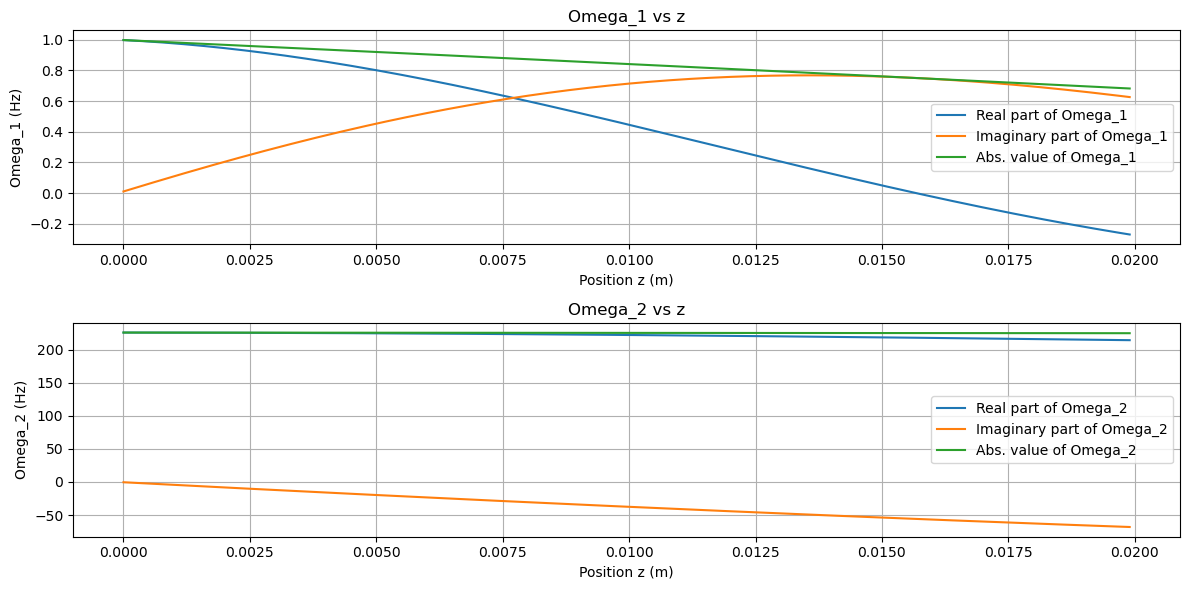

In [70]:
# Backend function to calculate OD based on user input
def calculate_OD_1(Om_1=1.0, delta_1=0.0, delta_2=0.0):
    n_rabi = 1
    Om_2_list = 6 * Gamma3 + 0j
    Om_1_list = Om_1 * Gamma3 + 0j
    
    nz = int(L / z)  # Number of z steps
    z_array = np.arange(nz) * z  # Array of z values
    
    # Initialize arrays to store Rabi frequencies at each z step
    Om_2_vs_z = []
    Om_1_vs_z = []

    for i in range(nz):
        #if i == nz/4 or i == nz/2 or i == 3*nz/4: 
        #print(f"Processing z step {i}/{nz}")
            
        # Initialize arrays to store rho31 and rho32
        rho31_values = []
        rho32_values = []
        
        for k in range(len(v_values)):                   
            
            Om_2_actual = Om_2_list      # Convert to actual Omega_2 in MHz
            Om_1_actual = Om_1_list      # Convert Om_1 to MHz
            
            delta_1_actual = delta_1 * Gamma3 + k_1 * v_values[k] / (10**6)
            delta_2_actual = delta_2 * Gamma3 + k_2 * v_values[k] / (10**6)

            # Define the imaginary unit
            I = 1j

            # Construct the matrix A
            A = np.array([
                # Row 1
                [Gamma31 + Gamma12, 0, I*Om_1_actual/2, 0, Gamma31 - Gamma21, 0, -I*np.conjugate(Om_1_actual)/2, 0],
                # Row 2
                [0, gamma12 - I*(delta_2_actual - delta_1_actual), I*Om_2_actual/2, 0, 0, 0, 0, -I*np.conjugate(Om_1_actual)/2],
                # Row 3
                [I*np.conjugate(Om_1_actual), I*np.conjugate(Om_2_actual)/2, gamma13 + I*delta_1_actual, 0, I*np.conjugate(Om_1_actual)/2, 0, 0, 0],
                # Row 4
                [0, 0, 0, gamma12 + I*(delta_2_actual - delta_1_actual), 0, I*Om_1_actual/2, -I*np.conjugate(Om_2_actual)/2, 0],
                # Row 5
                [Gamma32 - Gamma12, 0, 0, 0, Gamma32 + Gamma21, I*Om_2_actual/2, 0, -I*np.conjugate(Om_2_actual)/2],
                # Row 6
                [I*np.conjugate(Om_2_actual)/2, 0, 0, I*np.conjugate(Om_1_actual)/2, I*np.conjugate(Om_2_actual), gamma23 + I*delta_2_actual, 0, 0],
                # Row 7
                [-I*Om_1_actual, 0, 0, -I*Om_2_actual/2, -I*Om_1_actual/2, 0, gamma13 - I*delta_1_actual, 0],
                # Row 8
                [-I*Om_2_actual/2, -I*Om_1_actual/2, 0, 0, -I*Om_2_actual, 0, 0, gamma23 - I*delta_2_actual]
            ], dtype=complex)

            # Construct the vector b
            b = np.array([
                Gamma31,
                0,
                I*np.conjugate(Om_1_actual)/2,
                0,
                Gamma32,
                I*np.conjugate(Om_2_actual)/2,
                -I*Om_1_actual/2,
                -I*Om_2_actual/2
            ], dtype=complex)
            
            try:
                v = np.linalg.solve(A, b)
            except np.linalg.LinAlgError:
                # Handle singular matrix
                print(f"Singular matrix at z step {i}, velocity index {k}")
                rho31 = np.nan
                rho32 = np.nan
            else:
                # Extract the solutions
                rho11 = np.real(v[0])
                rho12 = v[1]
                rho13 = v[2]
                rho21 = v[3]
                rho22 = np.real(v[4])
                rho23 = v[5]
                rho31 = v[6]
                rho32 = v[7]

            # Compute rho33
            rho33 = 1 - rho11 - rho22

            # Store the populations
            rho31_values.append(rho31)
            rho32_values.append(rho32)  

        # Compute the weighted sums using dot product
        rho32_val = np.sum(rho32_values * weights * dv) / np.sum(weights * dv)
        rho31_val = np.sum(rho31_values * weights * dv) / np.sum(weights * dv)
                
        # Update the Rabi frequencies
        Om_2_list = Om_2_actual + z * (1j) * (k_2 / (epsilon_0 * hbar)) * N * rho32_val * mu_23**2 / (10**6)
        Om_1_list = Om_1_actual + z * (1j) * (k_1 / (epsilon_0 * hbar)) * N * rho31_val * mu_13**2 / (10**6)
        
        #min_threshold = 1e-16  # Physically justified minimum value

        #if np.abs(Om_1_list) < min_threshold:
            #Om_1_list = min_threshold * np.exp(1j * np.angle(Om_1_list))
            #print(f"Om_1_list capped at step {i}")

        #if np.abs(Om_2_list) < min_threshold:
            #Om_2_list = min_threshold * np.exp(1j * np.angle(Om_2_list))
            #print(f"Om_2_list capped at step {i}")
        
        # Record Rabi frequencies at this z step
        Om_2_vs_z.append(Om_2_list.copy())
        Om_1_vs_z.append(Om_1_list.copy())

    # Convert lists to numpy arrays
    Om_2_vs_z = np.array(Om_2_vs_z)  # Shape: (nz, n_rabi)
    Om_1_vs_z = np.array(Om_1_vs_z)
    
    return Om_2_vs_z, Om_1_vs_z, z_array

def plot_OD(Om_1: list,delta_1: list, delta_2):
    
    Om_2_vs_z, Om_1_vs_z, z_array = calculate_OD_1(Om_1, delta_1, delta_2)
    
    # Extract real and imaginary parts
    Om_1_real = np.real(Om_1_vs_z)
    Om_1_imag = np.imag(Om_1_vs_z)
    Om_2_real = np.real(Om_2_vs_z)
    Om_2_imag = np.imag(Om_2_vs_z)

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot Omega_1
    plt.subplot(2, 1, 1)
    plt.plot(z_array, Om_1_real/(Gamma3*Om_1), label='Real part of Omega_1')
    plt.plot(z_array, Om_1_imag/(Gamma3*Om_1), label='Imaginary part of Omega_1')
    plt.plot(z_array, np.abs(Om_1_vs_z)/(Gamma3*Om_1), label='Abs. value of Omega_1')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_1 (Hz)')
    plt.title('Omega_1 vs z')
    plt.legend()
    plt.grid(True)

    # Plot Omega_2
    plt.subplot(2, 1, 2)
    plt.plot(z_array, Om_2_real, label='Real part of Omega_2')
    plt.plot(z_array, Om_2_imag, label='Imaginary part of Omega_2')
    plt.plot(z_array, np.abs(Om_2_vs_z), label='Abs. value of Omega_2')
    plt.xlabel('Position z (m)')
    plt.ylabel('Omega_2 (Hz)')
    plt.title('Omega_2 vs z')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Create the button to start the simulation
run_button = widgets.Button(
    description="Run Simulation",
    button_style='success',  # 'success', 'info', 'warning', 'danger' or '' (default)
    tooltip='Click to run the simulation',
    icon='play'
)

# Function to be triggered when the button is clicked
def run_simulation(b):
    # Extract the current slider values
    Om_1 = 1
    delta_1 = 0.5
    delta_2 = 0
    
    # Call the plot_OD function with these values
    plot_OD(Om_1, delta_1, delta_2)

# Attach the function to the button
run_button.on_click(run_simulation)

# Display the sliders and the button
display(run_button)
